<a href="https://colab.research.google.com/github/SINSU00/asdf/blob/master/%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%83%9D%EC%84%B1_%EB%AA%A8%EB%8D%B8_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("GPU is", "avallable" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

import tensorflow as tf
from tensorflow.keras import layers  #Keras의 고수준 신경망 API
import matplotlib.pyplot as plt      #시각화를 위한 라이브러리
import numpy as np                   #수치 계산을 위한 라이브러리
import os                            #운영 체제와 상호작용하는 라이브러리
import time                          #시간 측정을 위해 사용됨
from IPython import display          #Colab에서 이미지를 표시하기 위한 라이브러리

GPU is avallable


In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def make_generator_model():        #생성자 모델을 정의
  model = tf.keras.Sequential()    #순차 모델을 생성
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(110,)))  #7x7x256 차원의 Dense레이어를 추가
  model.add(layers.BatchNormalization())  #배치 정규화를 수행
  model.add(layers.LeakyReLU())           #Leaky ReLU 활성화 함수를 적용
  model.add(layers.Reshape((7, 7, 256)))  #출력을 7x7x256 크기로 재구성

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #5x5 필터를 사용하며 2D전치 합성곱 레이어를 추가
  model.add(layers.BatchNormalization())       #strides=(1, 1)는 이동크기를 설정, padding='same'은 입력과 출력의 크기를 동일하게 유지
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
                                #출력층을 정의하며, tanh 활성화 함수를 사용, 이는 출력을 [-1, 1] 범위로 정규화함
  return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1379840   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [ ]:
def make_discriminator_model():  #판별자 모델 정의
  model = tf.keras.Sequential()  #순차 모델을 생성
  #5x5 필터와 64개의 채널을 가진 2D합성곱 레이어를 추가               입력이미지의 크기를 설정
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())  #Leaky ReLU 활성화 함수 적용
  model.add(layers.Dropout(0.3)) #30%의 드롭아웃을 적용

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())  #출력을 일차원으로 변환
  model.add(layers.Dense(1))   #최종 출력을 위한 Dense 레이어를 추가

  return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  #바이너리 크로스엔트로피 손실 함수를 정의

def discriminator_loss(real_output, fake_output):  #판별자의 손실을 계산
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)  #진짜 이미지의 대한 손실을 계산
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #가짜 이미지의 대한 손실을 계산
  total_loss = real_loss + fake_loss #진짜 이미지와 가짜 이미지에 대한 손실의 합
  return total_loss

def generator_loss(fake_output): #생성자의 손실을 계산하며, 가짜 이미지를 진짜로 잘못 분류하도록 학습
  return cross_entropy(tf.ones_like(fake_output), fake_output)

#밑에 두 변수는 Adam 옵티마이저를 사용하여 생성자와 판별자를 최적화함
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50           #총 훈련 횟수 설정
noise_dim = 100       #생성자의 입력으로 사용할 노이즈 벡터의 차원을 정의함
num_examples_to_generate = 16     #시각화를 위해 한 번에 생성할 이미지의 수를 설정

seed = tf.random.normal([num_examples_to_generate, noise_dim])  #고정된 랜덤 노이즈를 생성하여 훈련 중간 결과를 시각화할 때 일관된 출력을 보장
labels = np.random.randint(0, 10, num_examples_to_generate).reshape(-1, 1)   #0부터 9까지의 랜덤 숫자를 생성
seed_labels = tf.keras.utils.to_categorical(labels, 10)   #해당 숫자를 원-핫 인코딩함

@tf.function
def train_step(images, labels):   #한 번의 훈련 스텝을 수행
  noise = tf.random.normal([BATCH_SIZE, noise_dim])  #노이즈 벡터를 생성
  labels = tf.one_hot(labels, depth=10)   #레이블을 원-핫 인코딩함
  noise = tf.concat([noise, labels], axis=1)  #노이즈와 레이블을 결합

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:   #생성자와 판별자의 그래디언트를 계산하는 데 사용
    generated_images = generator(noise, training=True)   #생성자를 사용하여 가짜 이미지를 생성

    real_output = discriminator(images, training=True)   #판별자를 사용하여 진짜 이미지를 평가
    fake_output = discriminator(generated_images, training=True)   #판별자를 사용하여 가짜 이미지를 평가

    gen_loss = generator_loss(fake_output)    #생성자의 손실을 계산
    disc_loss = discriminator_loss(real_output, fake_output)    #판별자의 손실을 계산

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)   #생성자의 그래디언트를 계산
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)   #판별자의 그래디언트를 계산

  #밑에 두 코드는 그래디언트를 사용하여 모델을 업데이트 함
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):   #전체 훈련 과정을 수행
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:  #각 에포크마다 데이터셋의 모든 배치를 사용하여 train_step을 호출
      train_step(image_batch, label_batch)

    display.clear_output(wait=True)          #훈련이 끝나면 generate_and_save_images를 호출하여 이미지를 생성하고 저장
    generate_and_save_images(generator, epoch + 1, seed, seed_labels)

    print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed, seed_labels)

def generate_and_save_images(model, epoch, test_input, test_labels):    #이미지를 생성하고 저장
  predictions = model(tf.concat([test_input, test_labels], axis=1), training=False) #테스트 입력과 레이블을 결합
                                #생성자를 사용하여 이미지를 생성, matplotlib을 사용하여 이미지를 시각화하고 저장
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig(f'image_at_epoch_{epoch:04d}.png')
  plt.show()

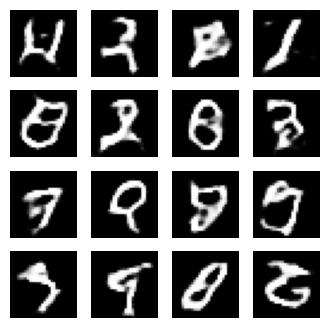

In [ ]:
train(train_dataset, EPOCHS)

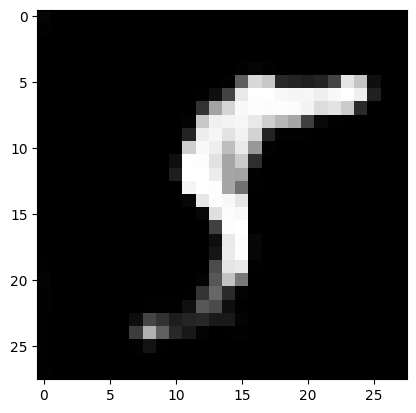

In [ ]:
def generate_specific_number(model, number):         #특정 숫자를 생성
  noise = tf.random.normal([1, noise_dim])           #노이즈 벡터를 생성
  label = tf.constant([number], dtype=tf.float32)    #생성할 숫자를 지정
  label = tf.keras.utils.to_categorical(label, 10)
  noise = tf.concat([noise, label], axis=1)          #노이즈와 레이블을 결합

  generated_image = model(noise, training=False)     #생성자를 사용하여 이미지를 만드는데, matplotlib을 사용하여 이미지를 시각화함
  plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.show()

generate_specific_number(generator, 5)  #숫자 5 생성